# Getting started

First things first, make sure you have [installed river](installation.md).

In `river`, features are represented with dictionaries, where the keys correspond to the features names. For instance:

In [1]:
import datetime as dt

x = {
    'shop': 'Ikea',
    'city': 'Stockholm',
    'date': dt.datetime(2020, 6, 1),
    'sales': 42
}

It is up to you, the user, to decide how to stream your data. `river` offers a `stream` module which has various utilities for handling streaming data, such as `stream.iter_csv`. For the sake of example, `river` also provides a `datasets` module which contains various streaming datasets. For example, the `datasets.Phishing` dataset contains records of [phishing](https://www.wikiwand.com/en/Phishing) attempts on web pages.

In [2]:
from river import datasets

dataset = datasets.Phishing()
print(dataset)

Phishing websites.

This dataset contains features from web pages that are classified as phishing or not.

    Name  Phishing                                                    
    Task  Binary classification                                       
 Samples  1,250                                                       
Features  9                                                           
  Sparse  False                                                       
    Path  /home/runner/work/river/river/river/datasets/phishing.csv.gz


The dataset is a streaming dataset, and therefore doesn't sit in memory. Instead, we can loop over each sample with a `for` loop:

In [3]:
for x, y in dataset:
    pass

print(x)

{'empty_server_form_handler': 1.0, 'popup_window': 0.5, 'https': 1.0, 'request_from_other_domain': 1.0, 'anchor_from_other_domain': 1.0, 'is_popular': 0.5, 'long_url': 0.0, 'age_of_domain': 0, 'ip_in_url': 0}


In [4]:
print(y)

False


Typically, models learn via a `learn_one(x, y)` method, which takes as input some features and a target value. Being able to learn with a single instance gives a lot of flexibility. For instance, a model can be updated whenever a new sample arrives from a stream. To exemplify this, let's train a logistic regression on the above dataset.

In [5]:
from river import linear_model

model = linear_model.LogisticRegression()

for x, y in dataset:
    model.learn_one(x, y)

Predictions can be obtained by calling a model's `predict_one` method. In the case of a classifier, we can also use `predict_proba_one` to produce probability estimates.

In [6]:
model = linear_model.LogisticRegression()

for x, y in dataset:
    y_pred = model.predict_proba_one(x)
    model.learn_one(x, y)
    
print(y_pred)

{False: 0.7731541581376543, True: 0.22684584186234572}


The `metrics` module gives access to many metrics that are commonly used in machine learning. Like the rest of `river`, these metrics can be updated with one element at a time:

In [7]:
from river import metrics

model = linear_model.LogisticRegression()

metric = metrics.ROCAUC()

for x, y in dataset:
    y_pred = model.predict_proba_one(x)
    model.learn_one(x, y)
    metric.update(y, y_pred)
    
metric

ROCAUC: 0.893565

A common way to improve the performance of a logistic regression is to scale the data. This can be done by using a `preprocessing.StandardScaler`. In particular, we can define a pipeline to organise our model into a sequence of steps:

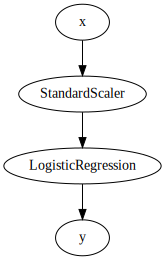

In [8]:
from river import compose
from river import preprocessing

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    linear_model.LogisticRegression()
)

model.draw()

In [9]:
metric = metrics.ROCAUC()

for x, y in datasets.Phishing():
    y_pred = model.predict_proba_one(x)
    model.learn_one(x, y)
    metric.update(y, y_pred)
    
metric

ROCAUC: 0.950363

As we can see, the model is performing much better now that the data is being scaled. Under the hood, the standard scaler maintains a running average and a running variance for each feature in the dataset. Each feature is thus scaled according to the average and the variance seen up to every given point in time.

This concludes this short guide to getting started with `river`. There is a lot more to discover and understand. Head towards the [user guide](/user-guide) for recipes on how to perform common machine learning tasks. You may also consult the [API reference](/api), which is a catalogue of all the modules that `river` exposes. Finally, the [examples](/examples) section contains comprehensive examples for various usecases.